In [1]:
import os
import matplotlib.pyplot as plt
import itertools
import pickle
import imageio
import PIL
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets, utils
from torch.autograd import Variable

%matplotlib inline

In [2]:
IMG_SIZE = 64
Z_DIMENSION = 32
BATCH_SIZE = 64
NUM_CHANNELS = 3
NUM_ITERATIONS = 100

In [3]:
class DoomFrameDataset(torch.utils.data.Dataset):
    def __init__(self, video_location, transform=None):
        """
        video_location (string): Path to the video file
        transform (function, optional): Transforms to apply
        """
        self.video_reader = imageio.get_reader(video_location,  'ffmpeg')
        
        #Read every fourth frame into memory, I/O was really slow without
        #Still roughly 20 FPS
        self.frames = [PIL.Image.fromarray(self.video_reader.get_data(idx)) 
                       for idx in range(len(self.video_reader)) 
                       if idx % 4 == 0]
        self.transform = transform

    def __len__(self):
        return len(self.frames)

    def __getitem__(self, idx):
        image = self.frames[idx]

        if self.transform:
            image = self.transform(image)

        return image

img_trans = transforms.Compose([transforms.Resize(IMG_SIZE),
                                transforms.CenterCrop(IMG_SIZE),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) #Bring to range of (-1, 1)
                               ])

doom_data = DoomFrameDataset("data/doom_gameplay.mp4", img_trans)

doom_loader = torch.utils.data.DataLoader(doom_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

In [4]:
class DoomGenerator(nn.Module):
    def __init__(self, hidden_units = 128):
        super(DoomGenerator, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(Z_DIMENSION, hidden_units*8, 4, 1, 0)
        self.deconv1_bn = nn.BatchNorm2d(hidden_units*8)
        self.deconv2 = nn.ConvTranspose2d(hidden_units*8, hidden_units*4, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(hidden_units*4)
        self.deconv3 = nn.ConvTranspose2d(hidden_units*4, hidden_units*2, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(hidden_units*2)
        self.deconv4 = nn.ConvTranspose2d(hidden_units*2, hidden_units, 4, 2, 1)
        self.deconv4_bn = nn.BatchNorm2d(hidden_units)
        self.deconv5 = nn.ConvTranspose2d(hidden_units, NUM_CHANNELS, 4, 2, 1)


    def forward(self, z_data):
        x = F.relu(self.deconv1_bn(self.deconv1(z_data)))
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = F.relu(self.deconv4_bn(self.deconv4(x)))
        x = F.tanh(self.deconv5(x))

        return x

doom_generator = DoomGenerator()

In [5]:
noise = torch.FloatTensor(BATCH_SIZE, Z_DIMENSION, 1, 1).normal_(0, 1)

doom_generator(Variable(noise)).size()

torch.Size([64, 3, 64, 64])

In [6]:
class DoomDiscriminator(nn.Module):
    def __init__(self, hidden_units=128):
        super(DoomDiscriminator, self).__init__()
        self.conv1 = nn.Conv2d(NUM_CHANNELS, hidden_units, 4, 2, 1)
        self.conv2 = nn.Conv2d(hidden_units, hidden_units*2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(hidden_units*2)
        self.conv3 = nn.Conv2d(hidden_units*2, hidden_units*4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(hidden_units*4)
        self.conv4 = nn.Conv2d(hidden_units*4, hidden_units*8, 4, 2, 1)
        self.conv4_bn = nn.BatchNorm2d(hidden_units*8)
        self.conv5 = nn.Conv2d(hidden_units*8, 1, 4, 1, 0)

    def forward(self, image):
        x = F.leaky_relu(self.conv1(image), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        x = F.sigmoid(self.conv5(x))

        return x

doom_discriminator = DoomDiscriminator()

In [7]:
doom_discriminator(Variable(doom_data[0].unsqueeze(0)))

Variable containing:
(0 ,0 ,.,.) = 
  0.4339
[torch.FloatTensor of size 1x1x1x1]

In [8]:
doom_discriminator(doom_generator(Variable(noise))).size()

torch.Size([64, 1, 1, 1])

In [9]:
doom_discriminator.cuda()
doom_generator.cuda()

DoomGenerator(
  (deconv1): ConvTranspose2d (32, 1024, kernel_size=(4, 4), stride=(1, 1))
  (deconv1_bn): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True)
  (deconv2): ConvTranspose2d (1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv2_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
  (deconv3): ConvTranspose2d (512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv3_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
  (deconv4): ConvTranspose2d (256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv4_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (deconv5): ConvTranspose2d (128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
)

In [10]:
noise = torch.FloatTensor(BATCH_SIZE, Z_DIMENSION, 1, 1)
fixed_noise = Variable(torch.FloatTensor(BATCH_SIZE, Z_DIMENSION, 1, 1).normal_(0, 1)).cuda()

disc_opt = optim.Adam(doom_discriminator.parameters(), lr=.0005, betas=(.5, 0.999))
gen_opt = optim.Adam(doom_generator.parameters(), lr=.0005, betas=(.5, 0.999))

binary_cross_entropy_loss = nn.BCELoss()

In [11]:
for epoch in range(1, NUM_ITERATIONS+1):
    for i, data in enumerate(doom_loader, start = 1):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        doom_discriminator.zero_grad()
        inputv = Variable(data).cuda()
        real_label = Variable(torch.FloatTensor(data.size(0)).fill_(1)).cuda()
        
        

        output = doom_discriminator(inputv)
        disc_real_loss = binary_cross_entropy_loss(output.squeeze(), real_label)
        disc_real_loss.backward()

        # train with fake
        noise.normal_(0, 1)
        noisev = Variable(noise).cuda()
        fake = doom_generator(noisev)
        output = doom_discriminator(fake.detach())
        fake_label = Variable(torch.FloatTensor(noise.size(0)).fill_(0)).cuda()
        disc_fake_loss = binary_cross_entropy_loss(output.squeeze(), fake_label)
        disc_fake_loss.backward()
        disc_loss = disc_real_loss + disc_fake_loss
        disc_opt.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        doom_generator.zero_grad()
        output = doom_discriminator(fake)
        real_label = Variable(torch.FloatTensor(output.size(0)).fill_(1)).cuda()

        gen_loss = binary_cross_entropy_loss(output.squeeze(), real_label)
        gen_loss.backward()
        gen_opt.step()

        print(f"""[{epoch}/{NUM_ITERATIONS}] :: [{i}/{len(doom_loader)}]
        Disc_Real_Loss: {disc_real_loss.data[0]} Disc_Fake_Loss: {disc_fake_loss.data[0]} Gen_Loss: {gen_loss.data[0]}""")
        if i % 100 == 0:
            utils.save_image(data,
                    'gan_files/real_samples.png',
                    normalize=True)
            fake = doom_generator(fixed_noise)
            utils.save_image(fake.data,
                    f'gan_files/fake_samples_epoch_{epoch}.png',
                    normalize=True)

    # do checkpointing
    torch.save(doom_generator.state_dict(), f'gan_files/latest.pth')
    torch.save(doom_discriminator.state_dict(), f'gan_files/latest.pth')

[0/25] :: [0/49]
        Disc_Real_Loss: 0.7763097286224365 Disc_Fake_Loss: 0.6858533024787903 Gen_Loss: 6.378675937652588
[0/25] :: [1/49]
        Disc_Real_Loss: 0.0023047428112477064 Disc_Fake_Loss: 3.478705406188965 Gen_Loss: 9.643059730529785
[0/25] :: [2/49]
        Disc_Real_Loss: 0.27782681584358215 Disc_Fake_Loss: 0.004496936686336994 Gen_Loss: 7.839637756347656
[0/25] :: [3/49]
        Disc_Real_Loss: 0.00281956372782588 Disc_Fake_Loss: 0.09009817242622375 Gen_Loss: 6.5297393798828125
[0/25] :: [4/49]
        Disc_Real_Loss: 0.0021428223699331284 Disc_Fake_Loss: 3.220167875289917 Gen_Loss: 8.226472854614258
[0/25] :: [5/49]
        Disc_Real_Loss: 0.11235407739877701 Disc_Fake_Loss: 0.009875379502773285 Gen_Loss: 6.560903549194336
[0/25] :: [6/49]
        Disc_Real_Loss: 0.04928269982337952 Disc_Fake_Loss: 0.04721523076295853 Gen_Loss: 4.434240818023682
[0/25] :: [7/49]
        Disc_Real_Loss: 0.01773875579237938 Disc_Fake_Loss: 1.091774344444275 Gen_Loss: 7.448447227478027
[

[1/25] :: [17/49]
        Disc_Real_Loss: 0.21311858296394348 Disc_Fake_Loss: 1.0003734827041626 Gen_Loss: 3.193039894104004
[1/25] :: [18/49]
        Disc_Real_Loss: 0.8056771755218506 Disc_Fake_Loss: 0.29536372423171997 Gen_Loss: 1.9109604358673096
[1/25] :: [19/49]
        Disc_Real_Loss: 0.16617654263973236 Disc_Fake_Loss: 2.5828113555908203 Gen_Loss: 5.473365783691406
[1/25] :: [20/49]
        Disc_Real_Loss: 4.227006912231445 Disc_Fake_Loss: 0.01903655007481575 Gen_Loss: 3.509398937225342
[1/25] :: [21/49]
        Disc_Real_Loss: 2.9219846725463867 Disc_Fake_Loss: 0.043563202023506165 Gen_Loss: 2.039201259613037
[1/25] :: [22/49]
        Disc_Real_Loss: 0.9019142389297485 Disc_Fake_Loss: 0.1858004629611969 Gen_Loss: 1.2504916191101074
[1/25] :: [23/49]
        Disc_Real_Loss: 0.29662537574768066 Disc_Fake_Loss: 0.397757351398468 Gen_Loss: 1.1184213161468506
[1/25] :: [24/49]
        Disc_Real_Loss: 0.144699826836586 Disc_Fake_Loss: 0.4578532576560974 Gen_Loss: 1.1754182577133179


[2/25] :: [34/49]
        Disc_Real_Loss: 0.8476344347000122 Disc_Fake_Loss: 0.2962459325790405 Gen_Loss: 1.729778528213501
[2/25] :: [35/49]
        Disc_Real_Loss: 0.7182542681694031 Disc_Fake_Loss: 0.6075731515884399 Gen_Loss: 1.5222232341766357
[2/25] :: [36/49]
        Disc_Real_Loss: 0.3224676251411438 Disc_Fake_Loss: 0.7064672708511353 Gen_Loss: 2.1728477478027344
[2/25] :: [37/49]
        Disc_Real_Loss: 0.3901060223579407 Disc_Fake_Loss: 0.35968974232673645 Gen_Loss: 2.3739142417907715
[2/25] :: [38/49]
        Disc_Real_Loss: 0.3336479663848877 Disc_Fake_Loss: 0.3896109461784363 Gen_Loss: 2.2657558917999268
[2/25] :: [39/49]
        Disc_Real_Loss: 0.17502345144748688 Disc_Fake_Loss: 0.6811303496360779 Gen_Loss: 3.1015892028808594
[2/25] :: [40/49]
        Disc_Real_Loss: 0.5203588604927063 Disc_Fake_Loss: 0.1650635153055191 Gen_Loss: 2.2478065490722656
[2/25] :: [41/49]
        Disc_Real_Loss: 0.11958091706037521 Disc_Fake_Loss: 0.39863845705986023 Gen_Loss: 2.44433879852294

[4/25] :: [2/49]
        Disc_Real_Loss: 0.45953184366226196 Disc_Fake_Loss: 0.5472781658172607 Gen_Loss: 1.5248655080795288
[4/25] :: [3/49]
        Disc_Real_Loss: 0.4995267987251282 Disc_Fake_Loss: 0.633482038974762 Gen_Loss: 1.3622959852218628
[4/25] :: [4/49]
        Disc_Real_Loss: 0.3779255747795105 Disc_Fake_Loss: 0.5761391520500183 Gen_Loss: 1.5542186498641968
[4/25] :: [5/49]
        Disc_Real_Loss: 0.23713825643062592 Disc_Fake_Loss: 0.6013741493225098 Gen_Loss: 1.820171594619751
[4/25] :: [6/49]
        Disc_Real_Loss: 0.6076415777206421 Disc_Fake_Loss: 0.7036138772964478 Gen_Loss: 1.8642477989196777
[4/25] :: [7/49]
        Disc_Real_Loss: 0.8859002590179443 Disc_Fake_Loss: 0.4510498046875 Gen_Loss: 1.7588696479797363
[4/25] :: [8/49]
        Disc_Real_Loss: 0.780247688293457 Disc_Fake_Loss: 0.57475745677948 Gen_Loss: 1.925980806350708
[4/25] :: [9/49]
        Disc_Real_Loss: 0.5865053534507751 Disc_Fake_Loss: 0.4825802445411682 Gen_Loss: 2.195499897003174
[4/25] :: [10/49

[5/25] :: [19/49]
        Disc_Real_Loss: 0.42668503522872925 Disc_Fake_Loss: 0.8238234519958496 Gen_Loss: 2.9295544624328613
[5/25] :: [20/49]
        Disc_Real_Loss: 1.42389714717865 Disc_Fake_Loss: 0.23300118744373322 Gen_Loss: 2.220336437225342
[5/25] :: [21/49]
        Disc_Real_Loss: 0.5472787022590637 Disc_Fake_Loss: 0.7616093158721924 Gen_Loss: 2.8994786739349365
[5/25] :: [22/49]
        Disc_Real_Loss: 0.7559951543807983 Disc_Fake_Loss: 0.4273134469985962 Gen_Loss: 1.9187626838684082
[5/25] :: [23/49]
        Disc_Real_Loss: 0.5532206296920776 Disc_Fake_Loss: 0.6468775272369385 Gen_Loss: 2.0382211208343506
[5/25] :: [24/49]
        Disc_Real_Loss: 0.5480237007141113 Disc_Fake_Loss: 0.9027420282363892 Gen_Loss: 2.977982997894287
[5/25] :: [25/49]
        Disc_Real_Loss: 0.6903618574142456 Disc_Fake_Loss: 0.36156076192855835 Gen_Loss: 2.1486971378326416
[5/25] :: [26/49]
        Disc_Real_Loss: 0.31884443759918213 Disc_Fake_Loss: 0.6258306503295898 Gen_Loss: 2.5151209831237793


[6/25] :: [36/49]
        Disc_Real_Loss: 0.43171757459640503 Disc_Fake_Loss: 0.6154096126556396 Gen_Loss: 1.7220990657806396
[6/25] :: [37/49]
        Disc_Real_Loss: 0.6162851452827454 Disc_Fake_Loss: 0.5454100370407104 Gen_Loss: 1.8984203338623047
[6/25] :: [38/49]
        Disc_Real_Loss: 0.39046090841293335 Disc_Fake_Loss: 0.5452944040298462 Gen_Loss: 2.450129985809326
[6/25] :: [39/49]
        Disc_Real_Loss: 0.47057557106018066 Disc_Fake_Loss: 0.3096151053905487 Gen_Loss: 2.0701968669891357
[6/25] :: [40/49]
        Disc_Real_Loss: 0.4512787461280823 Disc_Fake_Loss: 0.44760286808013916 Gen_Loss: 2.0162737369537354
[6/25] :: [41/49]
        Disc_Real_Loss: 0.3891768455505371 Disc_Fake_Loss: 0.5234031677246094 Gen_Loss: 2.3069825172424316
[6/25] :: [42/49]
        Disc_Real_Loss: 0.3886733651161194 Disc_Fake_Loss: 0.5766816735267639 Gen_Loss: 3.1386265754699707
[6/25] :: [43/49]
        Disc_Real_Loss: 0.7353626489639282 Disc_Fake_Loss: 0.258260577917099 Gen_Loss: 1.856738090515136

[8/25] :: [4/49]
        Disc_Real_Loss: 0.9450221061706543 Disc_Fake_Loss: 0.38173115253448486 Gen_Loss: 1.6189275979995728
[8/25] :: [5/49]
        Disc_Real_Loss: 0.24669276177883148 Disc_Fake_Loss: 1.0205893516540527 Gen_Loss: 3.8857741355895996
[8/25] :: [6/49]
        Disc_Real_Loss: 1.6587891578674316 Disc_Fake_Loss: 0.0767270103096962 Gen_Loss: 1.4614840745925903
[8/25] :: [7/49]
        Disc_Real_Loss: 0.17481961846351624 Disc_Fake_Loss: 0.883181095123291 Gen_Loss: 1.6291654109954834
[8/25] :: [8/49]
        Disc_Real_Loss: 0.2386888861656189 Disc_Fake_Loss: 0.6871652603149414 Gen_Loss: 2.2412850856781006
[8/25] :: [9/49]
        Disc_Real_Loss: 0.7033919095993042 Disc_Fake_Loss: 0.5028233528137207 Gen_Loss: 1.6935945749282837
[8/25] :: [10/49]
        Disc_Real_Loss: 0.39340630173683167 Disc_Fake_Loss: 0.5281985998153687 Gen_Loss: 1.8440204858779907
[8/25] :: [11/49]
        Disc_Real_Loss: 0.6880638003349304 Disc_Fake_Loss: 0.4761132597923279 Gen_Loss: 1.7527490854263306
[8/

[9/25] :: [21/49]
        Disc_Real_Loss: 0.6438843011856079 Disc_Fake_Loss: 0.14955851435661316 Gen_Loss: 1.7136647701263428
[9/25] :: [22/49]
        Disc_Real_Loss: 0.2091514766216278 Disc_Fake_Loss: 0.7981665134429932 Gen_Loss: 3.2826054096221924
[9/25] :: [23/49]
        Disc_Real_Loss: 0.8291757106781006 Disc_Fake_Loss: 0.15435132384300232 Gen_Loss: 2.1364126205444336
[9/25] :: [24/49]
        Disc_Real_Loss: 0.28689825534820557 Disc_Fake_Loss: 0.5106293559074402 Gen_Loss: 2.4398255348205566
[9/25] :: [25/49]
        Disc_Real_Loss: 0.3178962469100952 Disc_Fake_Loss: 0.6384727954864502 Gen_Loss: 3.7330546379089355
[9/25] :: [26/49]
        Disc_Real_Loss: 1.2358603477478027 Disc_Fake_Loss: 0.21526367962360382 Gen_Loss: 1.450782299041748
[9/25] :: [27/49]
        Disc_Real_Loss: 0.3616372346878052 Disc_Fake_Loss: 1.4970170259475708 Gen_Loss: 3.068641185760498
[9/25] :: [28/49]
        Disc_Real_Loss: 1.2295465469360352 Disc_Fake_Loss: 0.42362895607948303 Gen_Loss: 1.89294147491455

[10/25] :: [38/49]
        Disc_Real_Loss: 0.49015575647354126 Disc_Fake_Loss: 0.3022238612174988 Gen_Loss: 2.332735061645508
[10/25] :: [39/49]
        Disc_Real_Loss: 0.24696069955825806 Disc_Fake_Loss: 0.40671679377555847 Gen_Loss: 2.970879077911377
[10/25] :: [40/49]
        Disc_Real_Loss: 0.8545899391174316 Disc_Fake_Loss: 0.25419896841049194 Gen_Loss: 1.6431994438171387
[10/25] :: [41/49]
        Disc_Real_Loss: 0.11921575665473938 Disc_Fake_Loss: 1.1468098163604736 Gen_Loss: 4.206705093383789
[10/25] :: [42/49]
        Disc_Real_Loss: 1.1031498908996582 Disc_Fake_Loss: 0.14159797132015228 Gen_Loss: 2.596590280532837
[10/25] :: [43/49]
        Disc_Real_Loss: 0.16577821969985962 Disc_Fake_Loss: 0.6499515175819397 Gen_Loss: 2.466845989227295
[10/25] :: [44/49]
        Disc_Real_Loss: 1.2211565971374512 Disc_Fake_Loss: 0.600975751876831 Gen_Loss: 1.5624291896820068
[10/25] :: [45/49]
        Disc_Real_Loss: 0.08838450908660889 Disc_Fake_Loss: 1.0344858169555664 Gen_Loss: 2.4839506

[12/25] :: [6/49]
        Disc_Real_Loss: 0.27896827459335327 Disc_Fake_Loss: 0.5474427938461304 Gen_Loss: 2.7663185596466064
[12/25] :: [7/49]
        Disc_Real_Loss: 0.4919712245464325 Disc_Fake_Loss: 0.25324583053588867 Gen_Loss: 1.9001655578613281
[12/25] :: [8/49]
        Disc_Real_Loss: 0.304408460855484 Disc_Fake_Loss: 0.6739879846572876 Gen_Loss: 3.9862616062164307
[12/25] :: [9/49]
        Disc_Real_Loss: 1.0926620960235596 Disc_Fake_Loss: 0.24847111105918884 Gen_Loss: 2.1279654502868652
[12/25] :: [10/49]
        Disc_Real_Loss: 0.3094383180141449 Disc_Fake_Loss: 0.5795124769210815 Gen_Loss: 2.3108162879943848
[12/25] :: [11/49]
        Disc_Real_Loss: 0.24775902926921844 Disc_Fake_Loss: 0.46005770564079285 Gen_Loss: 3.4772207736968994
[12/25] :: [12/49]
        Disc_Real_Loss: 0.48126915097236633 Disc_Fake_Loss: 0.15960147976875305 Gen_Loss: 2.2879104614257812
[12/25] :: [13/49]
        Disc_Real_Loss: 0.2501305341720581 Disc_Fake_Loss: 0.5381038188934326 Gen_Loss: 2.9094707

[13/25] :: [23/49]
        Disc_Real_Loss: 0.5053004622459412 Disc_Fake_Loss: 0.4534043073654175 Gen_Loss: 2.035968780517578
[13/25] :: [24/49]
        Disc_Real_Loss: 0.18533200025558472 Disc_Fake_Loss: 0.945008397102356 Gen_Loss: 3.1003544330596924
[13/25] :: [25/49]
        Disc_Real_Loss: 1.1517562866210938 Disc_Fake_Loss: 0.1903817057609558 Gen_Loss: 1.4131016731262207
[13/25] :: [26/49]
        Disc_Real_Loss: 0.2475174069404602 Disc_Fake_Loss: 0.7819830179214478 Gen_Loss: 2.5940704345703125
[13/25] :: [27/49]
        Disc_Real_Loss: 0.6031613945960999 Disc_Fake_Loss: 0.24589700996875763 Gen_Loss: 1.870197057723999
[13/25] :: [28/49]
        Disc_Real_Loss: 0.33673107624053955 Disc_Fake_Loss: 0.6199548244476318 Gen_Loss: 2.4053125381469727
[13/25] :: [29/49]
        Disc_Real_Loss: 0.5878892540931702 Disc_Fake_Loss: 0.3607025444507599 Gen_Loss: 2.533252477645874
[13/25] :: [30/49]
        Disc_Real_Loss: 0.5957674980163574 Disc_Fake_Loss: 0.41926103830337524 Gen_Loss: 1.793084859

[14/25] :: [40/49]
        Disc_Real_Loss: 0.3775266408920288 Disc_Fake_Loss: 0.5086991786956787 Gen_Loss: 2.542656421661377
[14/25] :: [41/49]
        Disc_Real_Loss: 0.7380416393280029 Disc_Fake_Loss: 0.23328986763954163 Gen_Loss: 1.4224720001220703
[14/25] :: [42/49]
        Disc_Real_Loss: 0.32342714071273804 Disc_Fake_Loss: 1.1451826095581055 Gen_Loss: 3.1760692596435547
[14/25] :: [43/49]
        Disc_Real_Loss: 1.2366487979888916 Disc_Fake_Loss: 0.17629195749759674 Gen_Loss: 1.1349966526031494
[14/25] :: [44/49]
        Disc_Real_Loss: 0.2791568338871002 Disc_Fake_Loss: 1.052846908569336 Gen_Loss: 2.5043082237243652
[14/25] :: [45/49]
        Disc_Real_Loss: 0.5882440805435181 Disc_Fake_Loss: 0.3107219636440277 Gen_Loss: 2.007699728012085
[14/25] :: [46/49]
        Disc_Real_Loss: 0.3580082654953003 Disc_Fake_Loss: 0.7679800987243652 Gen_Loss: 2.6054625511169434
[14/25] :: [47/49]
        Disc_Real_Loss: 0.8947309255599976 Disc_Fake_Loss: 0.35310208797454834 Gen_Loss: 1.45446360

[16/25] :: [8/49]
        Disc_Real_Loss: 0.4385451376438141 Disc_Fake_Loss: 0.5621835589408875 Gen_Loss: 2.632169008255005
[16/25] :: [9/49]
        Disc_Real_Loss: 0.7694258689880371 Disc_Fake_Loss: 0.2060556709766388 Gen_Loss: 1.2170246839523315
[16/25] :: [10/49]
        Disc_Real_Loss: 0.13834378123283386 Disc_Fake_Loss: 1.3808238506317139 Gen_Loss: 3.8889074325561523
[16/25] :: [11/49]
        Disc_Real_Loss: 1.3421354293823242 Disc_Fake_Loss: 0.1357327550649643 Gen_Loss: 1.7802037000656128
[16/25] :: [12/49]
        Disc_Real_Loss: 0.3271777033805847 Disc_Fake_Loss: 0.6245481371879578 Gen_Loss: 1.7671493291854858
[16/25] :: [13/49]
        Disc_Real_Loss: 0.27448323369026184 Disc_Fake_Loss: 0.5539368391036987 Gen_Loss: 2.681318759918213
[16/25] :: [14/49]
        Disc_Real_Loss: 0.5321192741394043 Disc_Fake_Loss: 0.37995344400405884 Gen_Loss: 2.289107084274292
[16/25] :: [15/49]
        Disc_Real_Loss: 0.3313072919845581 Disc_Fake_Loss: 0.7214642763137817 Gen_Loss: 2.97233033180

[17/25] :: [25/49]
        Disc_Real_Loss: 0.3489457964897156 Disc_Fake_Loss: 0.6755164265632629 Gen_Loss: 3.177748441696167
[17/25] :: [26/49]
        Disc_Real_Loss: 0.8214852809906006 Disc_Fake_Loss: 0.15199510753154755 Gen_Loss: 1.8173896074295044
[17/25] :: [27/49]
        Disc_Real_Loss: 0.3963016867637634 Disc_Fake_Loss: 0.6064903736114502 Gen_Loss: 1.9027256965637207
[17/25] :: [28/49]
        Disc_Real_Loss: 0.3202335834503174 Disc_Fake_Loss: 0.8188374042510986 Gen_Loss: 3.0498175621032715
[17/25] :: [29/49]
        Disc_Real_Loss: 1.2363128662109375 Disc_Fake_Loss: 0.21238172054290771 Gen_Loss: 1.5096826553344727
[17/25] :: [30/49]
        Disc_Real_Loss: 0.2349374145269394 Disc_Fake_Loss: 0.8709136247634888 Gen_Loss: 3.171222686767578
[17/25] :: [31/49]
        Disc_Real_Loss: 0.644736647605896 Disc_Fake_Loss: 0.25610971450805664 Gen_Loss: 2.2556729316711426
[17/25] :: [32/49]
        Disc_Real_Loss: 0.4529656767845154 Disc_Fake_Loss: 0.5539416670799255 Gen_Loss: 2.286984682

[18/25] :: [42/49]
        Disc_Real_Loss: 0.6763522624969482 Disc_Fake_Loss: 0.3631192445755005 Gen_Loss: 2.2950987815856934
[18/25] :: [43/49]
        Disc_Real_Loss: 0.8059588074684143 Disc_Fake_Loss: 0.35965782403945923 Gen_Loss: 1.06899094581604
[18/25] :: [44/49]
        Disc_Real_Loss: 0.127669557929039 Disc_Fake_Loss: 1.2497756481170654 Gen_Loss: 3.6845226287841797
[18/25] :: [45/49]
        Disc_Real_Loss: 1.2983793020248413 Disc_Fake_Loss: 0.1012079045176506 Gen_Loss: 1.4237840175628662
[18/25] :: [46/49]
        Disc_Real_Loss: 0.35700392723083496 Disc_Fake_Loss: 0.5276899933815002 Gen_Loss: 1.479324460029602
[18/25] :: [47/49]
        Disc_Real_Loss: 0.22603239119052887 Disc_Fake_Loss: 0.7587488889694214 Gen_Loss: 2.613426923751831
[18/25] :: [48/49]
        Disc_Real_Loss: 0.7746449708938599 Disc_Fake_Loss: 0.20833241939544678 Gen_Loss: 1.8803176879882812
[19/25] :: [0/49]
        Disc_Real_Loss: 0.33996137976646423 Disc_Fake_Loss: 0.6054158210754395 Gen_Loss: 2.2744202613

[20/25] :: [10/49]
        Disc_Real_Loss: 0.08327247202396393 Disc_Fake_Loss: 1.4639296531677246 Gen_Loss: 5.512775421142578
[20/25] :: [11/49]
        Disc_Real_Loss: 1.3746662139892578 Disc_Fake_Loss: 0.02053726091980934 Gen_Loss: 2.7305378913879395
[20/25] :: [12/49]
        Disc_Real_Loss: 0.40394127368927 Disc_Fake_Loss: 0.332116961479187 Gen_Loss: 1.3068928718566895
[20/25] :: [13/49]
        Disc_Real_Loss: 0.18281233310699463 Disc_Fake_Loss: 0.7704598903656006 Gen_Loss: 2.67511248588562
[20/25] :: [14/49]
        Disc_Real_Loss: 0.5560487508773804 Disc_Fake_Loss: 0.18820813298225403 Gen_Loss: 1.9045906066894531
[20/25] :: [15/49]
        Disc_Real_Loss: 0.1798323094844818 Disc_Fake_Loss: 0.6060174107551575 Gen_Loss: 2.7118079662323
[20/25] :: [16/49]
        Disc_Real_Loss: 0.5288064479827881 Disc_Fake_Loss: 0.47965386509895325 Gen_Loss: 2.4753222465515137
[20/25] :: [17/49]
        Disc_Real_Loss: 0.6948893666267395 Disc_Fake_Loss: 0.4846329689025879 Gen_Loss: 1.7721424102783

[21/25] :: [27/49]
        Disc_Real_Loss: 0.1459328681230545 Disc_Fake_Loss: 1.2265684604644775 Gen_Loss: 4.854606628417969
[21/25] :: [28/49]
        Disc_Real_Loss: 1.4283384084701538 Disc_Fake_Loss: 0.16969822347164154 Gen_Loss: 1.303421974182129
[21/25] :: [29/49]
        Disc_Real_Loss: 0.19911989569664001 Disc_Fake_Loss: 0.8780083656311035 Gen_Loss: 2.8712034225463867
[21/25] :: [30/49]
        Disc_Real_Loss: 0.3492199182510376 Disc_Fake_Loss: 0.40005797147750854 Gen_Loss: 3.480820417404175
[21/25] :: [31/49]
        Disc_Real_Loss: 0.8757361173629761 Disc_Fake_Loss: 0.20854483544826508 Gen_Loss: 1.2591488361358643
[21/25] :: [32/49]
        Disc_Real_Loss: 0.12639746069908142 Disc_Fake_Loss: 1.1439599990844727 Gen_Loss: 4.0975847244262695
[21/25] :: [33/49]
        Disc_Real_Loss: 1.6149439811706543 Disc_Fake_Loss: 0.07357799261808395 Gen_Loss: 1.326505184173584
[21/25] :: [34/49]
        Disc_Real_Loss: 0.13743272423744202 Disc_Fake_Loss: 1.0975459814071655 Gen_Loss: 2.796846

[22/25] :: [44/49]
        Disc_Real_Loss: 0.11177963018417358 Disc_Fake_Loss: 0.9558238387107849 Gen_Loss: 4.386180877685547
[22/25] :: [45/49]
        Disc_Real_Loss: 1.0640394687652588 Disc_Fake_Loss: 0.09872153401374817 Gen_Loss: 1.3396425247192383
[22/25] :: [46/49]
        Disc_Real_Loss: 0.12931272387504578 Disc_Fake_Loss: 1.1179497241973877 Gen_Loss: 4.250940322875977
[22/25] :: [47/49]
        Disc_Real_Loss: 0.6268215775489807 Disc_Fake_Loss: 0.12678387761116028 Gen_Loss: 2.5490174293518066
[22/25] :: [48/49]
        Disc_Real_Loss: 0.4272131323814392 Disc_Fake_Loss: 0.47598546743392944 Gen_Loss: 1.8884642124176025
[23/25] :: [0/49]
        Disc_Real_Loss: 0.19527164101600647 Disc_Fake_Loss: 1.1428461074829102 Gen_Loss: 4.845376014709473
[23/25] :: [1/49]
        Disc_Real_Loss: 1.7359600067138672 Disc_Fake_Loss: 0.07663256675004959 Gen_Loss: 1.2501591444015503
[23/25] :: [2/49]
        Disc_Real_Loss: 0.2651522159576416 Disc_Fake_Loss: 0.9394593238830566 Gen_Loss: 2.97195768

[24/25] :: [12/49]
        Disc_Real_Loss: 0.21812856197357178 Disc_Fake_Loss: 0.35010629892349243 Gen_Loss: 3.593668222427368
[24/25] :: [13/49]
        Disc_Real_Loss: 0.6195234060287476 Disc_Fake_Loss: 0.16277015209197998 Gen_Loss: 1.9882291555404663
[24/25] :: [14/49]
        Disc_Real_Loss: 0.13374662399291992 Disc_Fake_Loss: 0.6601467728614807 Gen_Loss: 3.500681161880493
[24/25] :: [15/49]
        Disc_Real_Loss: 0.35009413957595825 Disc_Fake_Loss: 0.28640708327293396 Gen_Loss: 3.3602113723754883
[24/25] :: [16/49]
        Disc_Real_Loss: 0.5085842609405518 Disc_Fake_Loss: 0.14088627696037292 Gen_Loss: 2.00185489654541
[24/25] :: [17/49]
        Disc_Real_Loss: 0.31308993697166443 Disc_Fake_Loss: 1.4783896207809448 Gen_Loss: 4.555923938751221
[24/25] :: [18/49]
        Disc_Real_Loss: 1.3780865669250488 Disc_Fake_Loss: 0.085723876953125 Gen_Loss: 1.9374866485595703
[24/25] :: [19/49]
        Disc_Real_Loss: 0.365353524684906 Disc_Fake_Loss: 0.7107282876968384 Gen_Loss: 2.24737596

In [12]:
import numpy as np

In [22]:
output.squeeze().cpu().data.numpy().shape

(3, 64, 64)

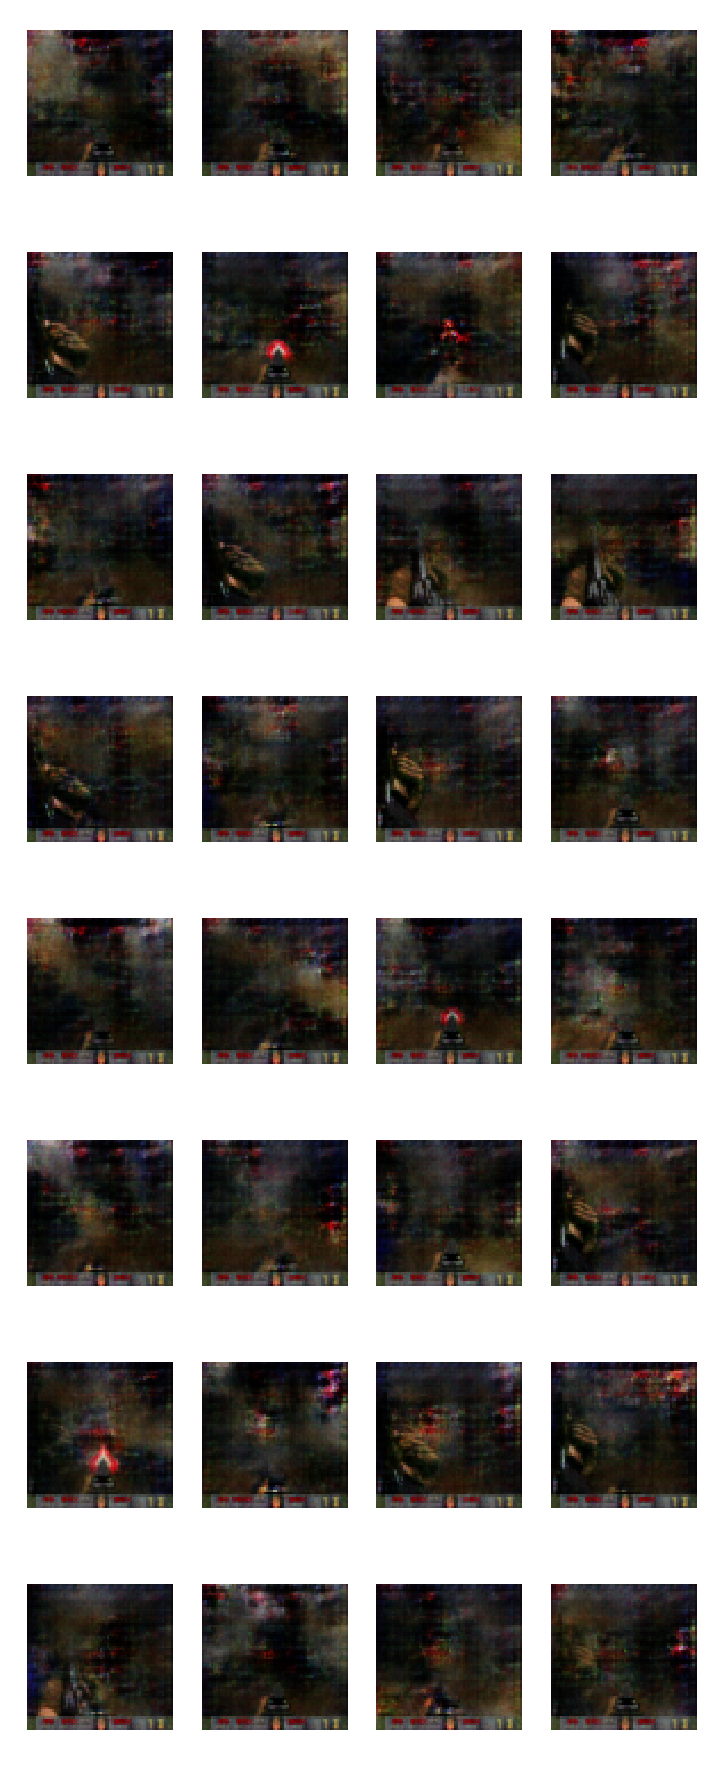

In [28]:
fig, axs = plt.subplots(8, 4, figsize = (12, 32), sharex = True, sharey = True)
for ax, dim in zip(axs.flatten(), range(Z_DIMENSION)):
    arr = np.zeros((1, Z_DIMENSION, 1, 1))
    arr[:,dim] = 1
    output = doom_generator(Variable(torch.Tensor(arr)).cuda())
    ax.axis('off')
    ax.imshow(output.squeeze().cpu().data.numpy().transpose(1, 2, 0) * .5 + .5)
